Device: cuda:0, Image Size: (3, 224, 224), Batch Size: 8, Epochs: 20
Classes: ['Damage', 'NoDamage'], K-Folds: 2


==================== FOLD 1/2 ====================

TrainData Size: 819, TrainData Batches: 103, ValData Size: 279, ValData Batches: 35
Epoch 1 TrainLoss: 0.6718 TrainAcc: 0.5678
Epoch 1 ValLoss: 0.6418 ValAcc: 0.6559

Epoch 2 TrainLoss: 0.5626 TrainAcc: 0.7326
Epoch 2 ValLoss: 0.6838 ValAcc: 0.5699

Epoch 3 TrainLoss: 0.4477 TrainAcc: 0.7949
Epoch 3 ValLoss: 0.6575 ValAcc: 0.6308

Epoch 4 TrainLoss: 0.3284 TrainAcc: 0.8620
Epoch 4 ValLoss: 0.6934 ValAcc: 0.6344

Epoch 5 TrainLoss: 0.2158 TrainAcc: 0.9182
Epoch 5 ValLoss: 0.6940 ValAcc: 0.6308

Epoch 6 TrainLoss: 0.1340 TrainAcc: 0.9475
Epoch 6 ValLoss: 0.7257 ValAcc: 0.6631

Epoch 7 TrainLoss: 0.1037 TrainAcc: 0.9621
Epoch 7 ValLoss: 0.7279 ValAcc: 0.6452

Epoch 8 TrainLoss: 0.0802 TrainAcc: 0.9756
Epoch 8 ValLoss: 0.8034 ValAcc: 0.7348

Epoch 9 TrainLoss: 0.0836 TrainAcc: 0.9707
Epoch 9 ValLoss: 0.8092 ValAcc: 0.7348

Ep

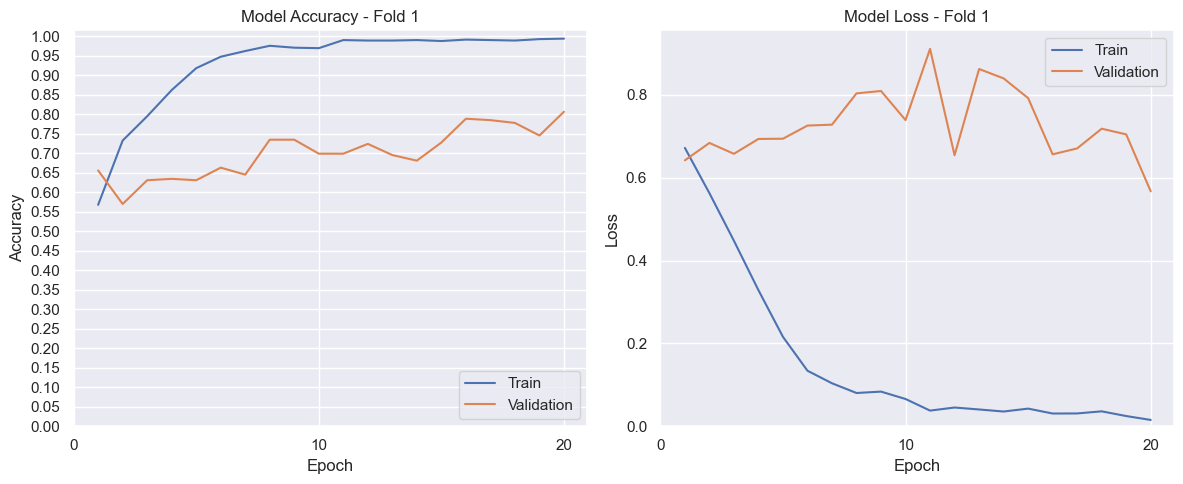

History files saved in ..\20241023Data\History\20250416_2343_fold1
Model in Epoch 10
Loss:  11.364879354834557
Accuracy:  0.7459016393442623

Model in Epoch 20
Loss:  9.43362267781049
Accuracy:  0.7622950819672131

best epoch:  20
TestLoss: 10.2204 TestAcc: 0.7623

Confusion Matrix:
[[46 17]
 [12 47]]

Classification Report:
              precision    recall  f1-score   support

      Damage       0.79      0.73      0.76        63
    NoDamage       0.73      0.80      0.76        59

    accuracy                           0.76       122
   macro avg       0.76      0.76      0.76       122
weighted avg       0.76      0.76      0.76       122

Classification results saved to: ..\20241023Data\Results\classification_results_fold1_20250416_2343.csv


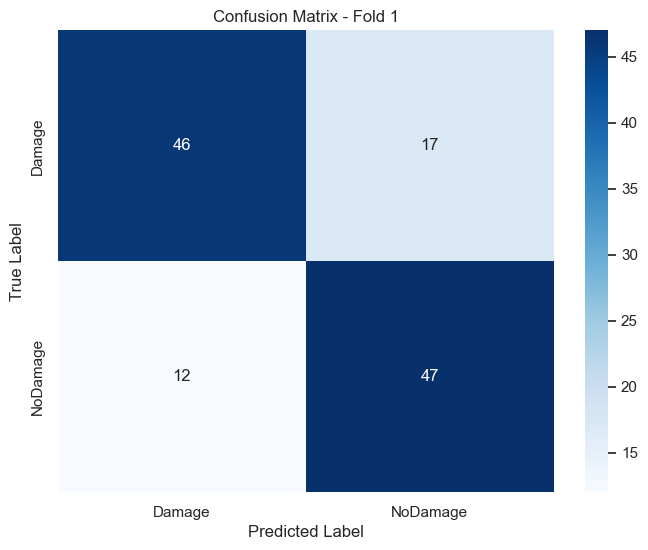

Fold 1 -Test Loss: 10.2204 Test Accuracy: 0.7623

==================== FOLD 2/2 ====================

TrainData Size: 819, TrainData Batches: 103, ValData Size: 279, ValData Batches: 35
Epoch 1 TrainLoss: 0.6661 TrainAcc: 0.5958
Epoch 1 ValLoss: 0.7899 ValAcc: 0.3763



KeyboardInterrupt: 

In [2]:
import glob
import os
import numpy as np
import torch
import torch.optim as optim
import torchvision.transforms as tv_tf
import torchvision.transforms.functional as TF
from torchvision.transforms import v2
import torchvision.models as models
import torch.nn as nn
import cv2
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, Subset
from pathlib import Path
from typing import List, Tuple
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import seaborn as sns; sns.set()
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import ConcatDataset
from PIL import Image, ImageEnhance

%matplotlib inline

# 時間の取得とフォーマット
time = datetime.datetime.now()
filedate = time.strftime('%Y%m%d_%H%M')

# デバイスの設定
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# 定数の設定
Channels = 3
batch_size = 8
IMG_SIZE = 224
valsplit = 0.25
k_folds = 5  # k分割交差検証のk値
epochlist=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
epochs = epochlist[-1]

#Augmentation関連の設定
brightness_list=[0.7, 1.0, 1.3]
contrast_list=[0.7, 1.0, 1.5]


# クラスの設定
Classes = ["Damage", "NoDamage"]
ClassNum = len(Classes)

# パス設定
trainpath = r"..\20241023Data\Train_KFold"
augpath = r"..\20241023Data\Train_KFold_BrightContrast"
savepath = r"..\20241023Data\Weights"
historypath = r"..\20241023Data\History"
resultspath = r"..\20241023Data\Results"

class MyDataset(Dataset):
    def __init__(self, root: str, dataset_transforms, Classes) -> None:
        super().__init__()
        self.dataset_transforms = dataset_transforms
        self.Classes = Classes
        self.data = list(sorted(Path(root).glob("*\*")))

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        data = self.data[index]
        img1 = cv2.cvtColor(cv2.imread(str(data)), cv2.COLOR_BGR2RGB)
        img1 = cv2.resize(img1, (IMG_SIZE, IMG_SIZE))
        img1 = TF.to_tensor(img1)

        # データの変形 (transforms)
        transformed_img = self.dataset_transforms(img1)

        # ラベル貼り
        label = str(data).split("\\")[-2]
        label = torch.tensor(self.Classes.index(label))
        
        # ファイルパスも返す（結果の分析用）
        return transformed_img, label, str(data)

    def __len__(self) -> int:
        return len(self.data)

#パスのリストを受け取ってaug済みフォルダのデータからデータセット作る
class AugDataset(Dataset):
    def __init__(self, path_list, dataset_transforms, Classes) -> None:
        super().__init__()
        self.dataset_transforms = dataset_transforms
        self.Classes = Classes
        self.data = path_list

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        data = self.data[index]
        img1 = cv2.cvtColor(cv2.imread(str(data)), cv2.COLOR_BGR2RGB)
        img1 = cv2.resize(img1, (IMG_SIZE, IMG_SIZE))
        img1 = TF.to_tensor(img1)

        # データの変形 (transforms)
        transformed_img = self.dataset_transforms(img1)

        # ラベル貼り
        label = str(data).split("\\")[-2]
        label = torch.tensor(self.Classes.index(label))
        
        # ファイルパスも返す（結果の分析用）
        return transformed_img, label, str(data)

    def __len__(self) -> int:
        return len(self.data)

# 入力データに施す処理
dataset_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0, 0, 0], std=[0.2, 0.2, 0.2]),
])


#データセットを受け取ってそこから画像のパスを全て取得し，Aug済みのパスに全て書き換えて，パスのリストとして返す　このパスのリストをAugDatasetが受け取る
def build_augmented_split(dataset):
    """
    samples_split: [(path_A, class_idx), ...]
    root_B: データセット B のルートディレクトリ
    → A のファイル名に対応する B のオリジナルと拡張版 (_B_C) を探し、
      存在すれば両方をリストに追加
    """
    out = []
    for _, _, path_normal in dataset:
        rel = os.path.relpath(path_normal, start=trainpath)  # e.g. "cat/0001.jpg"
        base, ext = os.path.splitext(rel)           # "cat/0001", ".jpg"
            
        for i in range(len(brightness_list)):
            for j in range(len(contrast_list)):
                # B の拡張版: basename + "_B_C" + ext
                aug_fname = base + "_B" + str(i)+ "C" + str(j) + ext
                aug_B     = os.path.join(augpath, aug_fname)

                if os.path.exists(aug_B):
                    out.append(aug_B)
                # 存在しなくても強制はしない
    return out


# モデルの初期化関数
def initialize_model():
    model = models.resnet50(weights='DEFAULT')
    #チャンネル数いじれるようにしておく
    model.conv1 = torch.nn.Conv2d(Channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, ClassNum)
    return model.to(device)

# 訓練関数
def train_model(model, trainloader, valloader, loss_fn, optimizer, num_epochs, fold):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    size = len(trainloader.dataset)
    num_batches = len(trainloader)
    size_val = len(valloader.dataset)
    num_batches_val = len(valloader)
    
    print(f"TrainData Size: {size}, TrainData Batches: {num_batches}, ValData Size: {size_val}, ValData Batches: {num_batches_val}")
    
    for epoch in range(num_epochs):
        running_loss, running_correct = 0, 0
        val_loss, val_correct = 0, 0
        
        # 訓練モード
        model.train()

        #_でreturnで帰ってくる３番目の戻り値は無視する
        for batch, (X, y, _) in enumerate(trainloader):
            X = X.to(device)
            y = y.to(device)
            
            # 予測と損失計算
            pred = model(X)
            loss = loss_fn(pred, y)
            
            # バックプロパゲーション
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 損失と正解数の合計を計算
            running_loss += loss.item()
            running_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
        epoch_loss = running_loss / num_batches
        epoch_acc = running_correct / size
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch + 1} TrainLoss: {epoch_loss:.4f} TrainAcc: {epoch_acc:.4f}')
        
        # 評価モード
        model.eval()
        with torch.no_grad():
            for X, y, _ in valloader:
                X = X.to(device)
                y = y.to(device)
                pred = model(X)
                val_loss += loss_fn(pred, y).item()
                val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                
            val_loss /= num_batches_val
            val_correct /= size_val
            
        val_losses.append(val_loss)
        val_accuracies.append(val_correct)
        
        print(f'Epoch {epoch + 1} ValLoss: {val_loss:.4f} ValAcc: {val_correct:.4f}')
        print()
        
        # 10 epoch毎にモデルを保存
        e1 = epoch + 1
        if (e1 % 10 == 0):
            os.makedirs(os.path.join(savepath, str(e1)), exist_ok=True)
            savepath2 = Path(savepath + "\\" + str(e1) + "\model_weights" + filedate +(f"_fold{fold}" if fold else "")+ ".pth")
            print('Saving Model...')
            torch.save(model.state_dict(), savepath2)
            print('Model saved in', savepath2)
            
    return model, train_losses, train_accuracies, val_losses, val_accuracies


#各エポックのモデルを評価する
def BestEpochModel_Evaluate(testloader, loss_fn, fold=None):
    epochmodel_accuracies=[]
    
    #各エポックで止めたモデルの中から最良のモデルを選択
    for e in epochlist:
        #モデル構築
        epochmodelpath = Path(savepath+"\\"+str(e)+"\model_weights"+filedate+(f"_fold{fold}" if fold else "")+".pth")
        epochmodel = initialize_model()
        epochmodel.load_state_dict(torch.load(epochmodelpath))
        #GPUにニューラルネットワークを渡す
        epochmodel=epochmodel.to(device)
    
        print("Model in Epoch", e)
        # テストデータでの評価
        epochmodel.eval()
        y_true = []
        y_pred = []
        file_paths = []
        size_test = len(testloader.dataset)
        test_loss, test_correct = 0, 0
        
        with torch.no_grad():
            for X, y, paths in testloader:
                X = X.to(device)
                y = y.to(device)
                outputs = epochmodel(X)
                #torch.maxの一番目の戻り値は確率．二番目の戻り値は，クラス番号　なのでクラス番号だけ取り出す
                _, predicted = torch.max(outputs, 1)
                
                test_loss += loss_fn(outputs, y).item()
                test_correct += (outputs.argmax(1) == y).type(torch.float).sum().item()
    
            test_correct /= size_test

        epochmodel_accuracies.append(test_correct)
        
        print("Loss: ", test_loss)
        print("Accuracy: ", test_correct)
        print()

    #エポックと精度の対応表からベストモデル算定
    ep_acc_df= pd.DataFrame({
        "epoch": epochlist, 
        "accuracy": epochmodel_accuracies
    })
    
    bestepoch = ep_acc_df.loc[ep_acc_df["accuracy"].idxmax(), "epoch"]

    #ベストモデル構築
    bestmodelpath = Path(savepath+"\\"+str(bestepoch)+"\model_weights"+filedate+(f"_fold{fold}" if fold else "")+".pth")
    bestmodel = initialize_model()
    bestmodel.load_state_dict(torch.load(bestmodelpath))
    #GPUにニューラルネットワークを渡す
    bestmodel=bestmodel.to(device)
    
    print("best epoch: ", bestepoch)

    return bestmodel
    


# 評価関数（混同行列と分類結果をCSVに出力）
def evaluate_model(model, testloader, loss_fn, fold=None):
    model.eval()
    y_true = []
    y_pred = []
    file_paths = []
    size_test = len(testloader.dataset)
    test_loss, test_correct = 0, 0
    
    with torch.no_grad():
        for X, y, paths in testloader:
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)
            #torch.maxの一番目の戻り値は確率．二番目の戻り値は，クラス番号　なのでクラス番号だけ取り出す
            _, predicted = torch.max(outputs, 1)
            
            test_loss += loss_fn(outputs, y).item()
            test_correct += (outputs.argmax(1) == y).type(torch.float).sum().item()

            #appendでリストにリストを追加するとリスト内にリストがある二重状態になってしまう　extend関数で2重リストにすることなく格納
            y_true.extend(y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            file_paths.extend(paths)

        test_correct /= size_test

    print(f'TestLoss: {test_loss:.4f} TestAcc: {test_correct:.4f}')
    
    # 混同行列の作成
    cm = confusion_matrix(y_true, y_pred)
    
    # 結果を出力
    print("\nConfusion Matrix:")
    print(cm)
    
    # 分類レポートの出力
    report = classification_report(y_true, y_pred, target_names=Classes)
    print("\nClassification Report:")
    print(report)
    
    # 分類結果をCSVに出力
    results_df = pd.DataFrame({
        'FilePath': file_paths,
        'TrueLabel': [Classes[i] for i in y_true],
        'PredictedLabel': [Classes[i] for i in y_pred],
        'Correct': [y_true[i] == y_pred[i] for i in range(len(y_true))]
    })
    
    # 結果ディレクトリがなければ作成
    os.makedirs(resultspath, exist_ok=True)
    
    # foldが指定されている場合は、フォルドごとの結果ファイルを作成
    if fold is not None:
        csv_path = os.path.join(resultspath, f"classification_results_fold{fold}_{filedate}.csv")
    else:
        csv_path = os.path.join(resultspath, f"classification_results_{filedate}.csv")
    
    results_df.to_csv(csv_path, index=False)
    print(f"Classification results saved to: {csv_path}")
    
    return cm, results_df, test_loss, test_correct

# 結果の可視化関数
def plot_results(train_losses, train_accuracies, val_losses, val_accuracies, fold=None):
    ep = np.arange(1, len(train_losses) + 1)
    
    # 精度のプロット
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(ep, train_accuracies)
    plt.plot(ep, val_accuracies)
    plt.title("Model Accuracy" + (f" - Fold {fold}" if fold else ""))
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.xticks(np.arange(0, len(train_losses) + 1, 10))
    plt.yticks(np.arange(0.0, 1.05, 0.05))
    plt.legend(["Train", "Validation"], loc="lower right")
    
    # 損失のプロット
    plt.subplot(1, 2, 2)
    plt.plot(ep, train_losses)
    plt.plot(ep, val_losses)
    plt.title("Model Loss" + (f" - Fold {fold}" if fold else ""))
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.xticks(np.arange(0, len(train_losses) + 1, 10))
    plt.ylim(bottom=0)
    plt.legend(["Train", "Validation"], loc="upper right")
    
    plt.tight_layout()
    
    # 結果を保存
    history_fold_path = historypath + "\\" + filedate + (f"_fold{fold}" if fold else "")
    os.makedirs(history_fold_path, exist_ok=True)
    plt.savefig(os.path.join(history_fold_path, "training_plot.png"))
    plt.show()
    
    # CSVにも保存
    pd.DataFrame(data=np.array([ep, train_accuracies]).T, columns=["Epoch", "Accuracy"]).to_csv(os.path.join(history_fold_path, "Train_Acc.csv"))
    pd.DataFrame(data=np.array([ep, train_losses]).T, columns=["Epoch", "Loss"]).to_csv(os.path.join(history_fold_path, "Train_Loss.csv"))
    pd.DataFrame(data=np.array([ep, val_accuracies]).T, columns=["Epoch", "Accuracy"]).to_csv(os.path.join(history_fold_path, "Val_Acc.csv"))
    pd.DataFrame(data=np.array([ep, val_losses]).T, columns=["Epoch", "Loss"]).to_csv(os.path.join(history_fold_path, "Val_Loss.csv"))
    print(f"History files saved in {history_fold_path}")

# 混同行列の可視化
def plot_confusion_matrix(cm, fold=None):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Classes, yticklabels=Classes)
    plt.title('Confusion Matrix' + (f" - Fold {fold}" if fold else ""))
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # 保存
    history_fold_path = historypath + "\\" + filedate + (f"_fold{fold}" if fold else "")
    os.makedirs(history_fold_path, exist_ok=True)
    plt.savefig(os.path.join(history_fold_path, "confusion_matrix.png"))
    plt.show()

# k分割交差検証を実行する関数
def run_k_fold_cross_validation(dataset, k_folds, num_epochs):
    # k-foldの初期化　shuffleは，k個に分割する直前に，各Foldに含まれるデータをランダムに選んでくれるよ（番号が連続したところで分けないよ）ってこと
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    # 各フォールドの精度を保存
    fold_accuracies = []
    fold_losses = []
    
    # 全データの添字を取得
    dataset_size = len(dataset)
    indices = list(range(dataset_size))

    #各フォールドごとにループ処理　その際に（訓練データに使うデータのIDリスト，検証データに使うデータのIDリスト）というリストをFoldごとにsplitで取得
    for fold, (train_ids, test_ids) in enumerate(kfold.split(indices)):
        print(f"\n{'='*20} FOLD {fold+1}/{k_folds} {'='*20}\n")
        
        # DataLoaderの作成
        train_subsampler = SubsetRandomSampler(train_ids)
        test_subsampler = SubsetRandomSampler(test_ids)
        
        # 訓練データをさらに訓練データと検証データに分割
        train_ids_split, val_ids = train_test_split(train_ids, test_size=valsplit, random_state=42)
        
        # Subsetを使用してデータセットを分割
        train_dataset = Subset(dataset, train_ids_split)
        val_dataset = Subset(dataset, val_ids)
        test_dataset = Subset(dataset, test_ids)

        #build_augmented_splitでKFoldのAug済データの，対応する画像のリストを取得　それでデータセット作る
        augimg_pathlist_train = build_augmented_split(train_dataset)
        augimg_pathlist_val = build_augmented_split(val_dataset)

        augmented_train_dataset = AugDataset(path_list=augimg_pathlist_train, dataset_transforms=dataset_transforms, Classes=Classes)
        augmented_val_dataset = AugDataset(path_list=augimg_pathlist_val, dataset_transforms=dataset_transforms, Classes=Classes)
        
        # DataLoaderの作成
        trainloader = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True)
        valloader = DataLoader(augmented_val_dataset, batch_size=batch_size, shuffle=True)
        testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

        # モデルの初期化
        model = initialize_model()
        
        # 損失関数とオプティマイザの定義
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        
        # モデルの訓練
        model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
            model, trainloader, valloader, loss_fn, optimizer, num_epochs, fold+1
        )
        
        # 結果の可視化
        plot_results(train_losses, train_accuracies, val_losses, val_accuracies, fold+1)

        bestmodel = BestEpochModel_Evaluate(testloader, loss_fn, fold+1)
        
        cm, results_df, test_loss, test_correct = evaluate_model(bestmodel, testloader, loss_fn, fold+1)
        
        # 混同行列の可視化
        plot_confusion_matrix(cm, fold+1)
        
        # モデルの保存
        os.makedirs(os.path.join(savepath, f"fold{fold+1}"), exist_ok=True)
        torch.save(bestmodel.state_dict(), os.path.join(savepath, f"fold{fold+1}", f"bestmodel_weights_{filedate}.pth"))
        
        # 最終精度を保存
        fold_accuracy = test_correct
        fold_loss = test_loss
        fold_accuracies.append(fold_accuracy)
        fold_losses.append(fold_loss)
        
        print(f"Fold {fold+1} -Test Loss: {fold_loss:.4f} Test Accuracy: {fold_accuracy:.4f}")
        
    # 全フォールドの平均精度を計算
    mean_accuracy = sum(fold_accuracies) / k_folds
    std_accuracy = np.std(fold_accuracies)
    mean_loss = sum(fold_losses) / k_folds
    std_loss = np.std(fold_losses)
    
    print(f"\n{'='*50}")
    print(f"K-Fold Cross Validation Results for k={k_folds}:")
    print(f"{'='*50}")

    for fold, loss in enumerate(fold_losses):
        print(f"Fold {fold+1}: {loss:.4f}")
    
    for fold, accuracy in enumerate(fold_accuracies):
        print(f"Fold {fold+1}: {accuracy:.4f}")
    
    print(f"{'='*50}")
    print(f"Average Loss: {mean_loss:.4f} ± {std_loss:.4f}")
    print(f"Average Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"{'='*50}")
    
    # クロスバリデーション結果をCSVに保存
    cv_results_df = pd.DataFrame({
        'Fold': [f"Fold {i+1}" for i in range(k_folds)],
        'Loss': fold_losses,
        'Accuracy': fold_accuracies
    })

    #DataFrameで各フォールドの値を書き終えた後に，平均値も書き込む
    # 既存のDataFrameに統計情報（平均、標準偏差）を追加
    cv_results_df.loc[k_folds] = ['Average Loss & Acc.', mean_loss, mean_accuracy]  # AccuracyはNoneで埋める
    cv_results_df.loc[k_folds + 1] = ['Std Dev Loss & Acc.', std_loss, std_accuracy]  # AccuracyはNoneで埋める

    cv_results_path = os.path.join(resultspath, f"cv_results_{filedate}.csv")
    cv_results_df.to_csv(cv_results_path, index=False)
    print(f"Cross validation results saved to: {cv_results_path}")
    
    return fold_losses, fold_accuracies, mean_loss, std_loss, mean_accuracy, std_accuracy
    
# メイン実行部分
if __name__ == "__main__":
    print(f"Device: {device}, Image Size: ({Channels}, {IMG_SIZE}, {IMG_SIZE}), Batch Size: {batch_size}, Epochs: {epochs}")
    print(f"Classes: {Classes}, K-Folds: {k_folds}\n")
    
    # データセットの準備
    dataset = MyDataset(root=trainpath, dataset_transforms=dataset_transforms, Classes=Classes)
    
    # k分割交差検証の実行
    fold_losses, fold_accuracies, mean_loss, std_loss, mean_accuracy, std_accuracy = run_k_fold_cross_validation(dataset, k_folds, epochs)
    
    print("\nTraining with Cross Validation Finished!!!")
    
    # 最終結果を表示
    print(f"\nFinal Results:")
    print(f"Average Accuracy across {k_folds} folds: {mean_loss:.4f} ± {std_loss:.4f} {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    
    # 計算終了時間の取得とフォーマット
    finishtime = datetime.datetime.now()
    finishdate = finishtime.strftime('%Y%m%d_%H%M')
    datepath=str(Path(resultspath + "\calc_time_" + filedate + ".txt"))
    
    # ファイルを新規作成し、日付を書き込む
    with open(datepath, 'w', encoding='utf-8') as f:
        f.write(filedate)
        f.write(finishdate)

    print("Calculation Finished in ", finishdate)